# Uplift Trees/Forests Visualization

## Introduction
This example notebooks illustrates how to visualize uplift trees for interpretation and diagnosis. 

#### Supported Models
These visualization functions work only for tree-based algorithms:

- Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
- Uplift tree/random forests on Contextual Treatment Selection

Currently, they are NOT supporting Meta-learner algorithms

- S-learner
- T-learner
- X-learner
- R-learner

#### Supported Usage
This notebook will show how to use visualization for:

- Uplift Tree and Uplift Random Forest
    - Visualize a trained uplift classification tree model
    - Visualize an uplift tree in a trained uplift random forests

- Training and Validation Data
    - Visualize the validation tree: fill the trained uplift classification tree with validation (or testing) data, and show the statistics for both training data and validation data
    
- One Treatment Group and Multiple Treatment Groups
    - Visualize the case where there are one control group and one treatment group
    - Visualize the case where there are one control group and multiple treatment groups



## Step 1 Load Modules

### Load CausalML modules

In [9]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

### Load standard modules

In [10]:
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

## One Control + One Treatment for Uplift Classification Tree 

In [11]:
# Data generation
df, x_names = make_uplift_classification()
print(x_names)
# Rename features for easy interpretation of visualization
x_names_new = ['feature_%s'%(i) for i in range(len(x_names))]
rename_dict = {x_names[i]:x_names_new[i] for i in range(len(x_names))}
df = df.rename(columns=rename_dict)
x_names = x_names_new
print(x_names)
df.head()

df = df[df['treatment_group_key'].isin(['control','treatment1'])]

# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

['x1_informative', 'x2_informative', 'x3_informative', 'x4_informative', 'x5_informative', 'x6_irrelevant', 'x7_irrelevant', 'x8_irrelevant', 'x9_irrelevant', 'x10_irrelevant', 'x11_uplift_increase', 'x12_uplift_increase', 'x13_increase_mix', 'x14_uplift_increase', 'x15_uplift_increase', 'x16_increase_mix', 'x17_uplift_increase', 'x18_uplift_increase', 'x19_increase_mix']
['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']


,mean,size
,conversion,conversion
treatment_group_key,,
control,0.5110,1000
treatment1,0.5140,1000
All,0.5125,2000


In [12]:
df, x_names = make_uplift_classification()
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [13]:
clf = UpliftTreeClassifier(control_name='control')
clf.fit(df_train[x_names].values,
         treatment=df_train['treatment_group_key'].values,
         y=df_train['conversion'].values)
p = clf.predict(df_test[x_names].values)

In [16]:
print(p)
print(type(clf))

[[0.50639386 0.51181102 0.57393484 0.50377834]
 [0.50639386 0.51181102 0.57393484 0.50377834]
 [0.58083832 0.45882353 0.50898204 0.45238095]
 ...
 [0.50639386 0.51181102 0.57393484 0.50377834]
 [0.50639386 0.51181102 0.57393484 0.50377834]
 [0.44444444 0.55555556 0.56451613 0.63414634]]
<class 'causalml.inference.tree.uplift.UpliftTreeClassifier'>


In [70]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [71]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

x18_uplift_increase >= -0.44234212654232735?
yes -> x11_uplift_increase >= 1.020659213325515?
		yes -> [0.3813559322033898, 0.6065573770491803]
		no  -> [0.5078125, 0.5267857142857143]
no  -> x10_irrelevant >= 0.8142773340486676?
		yes -> [0.4596774193548387, 0.61]
		no  -> x5_informative >= 0.280545459525536?
				yes -> [0.5522875816993464, 0.4143302180685358]
				no  -> [0.5070422535211268, 0.5748031496062992]


#### Read the tree
- First line: node split condition
- impurity: the value for the loss function
- total_sample: total sample size in this node
- group_sample: sample size by treatment group
- uplift score: the treatment effect between treatment and control (when there are multiple treatment groups, this is the maximum of the treatment effects)
- uplift p_value: the p_value for the treatment effect
- validation uplift score: when validation data is filled in the tree, this reflects the uplift score based on the - validation data. It can be compared with the uplift score (for training data) to check if there are over-fitting issue.

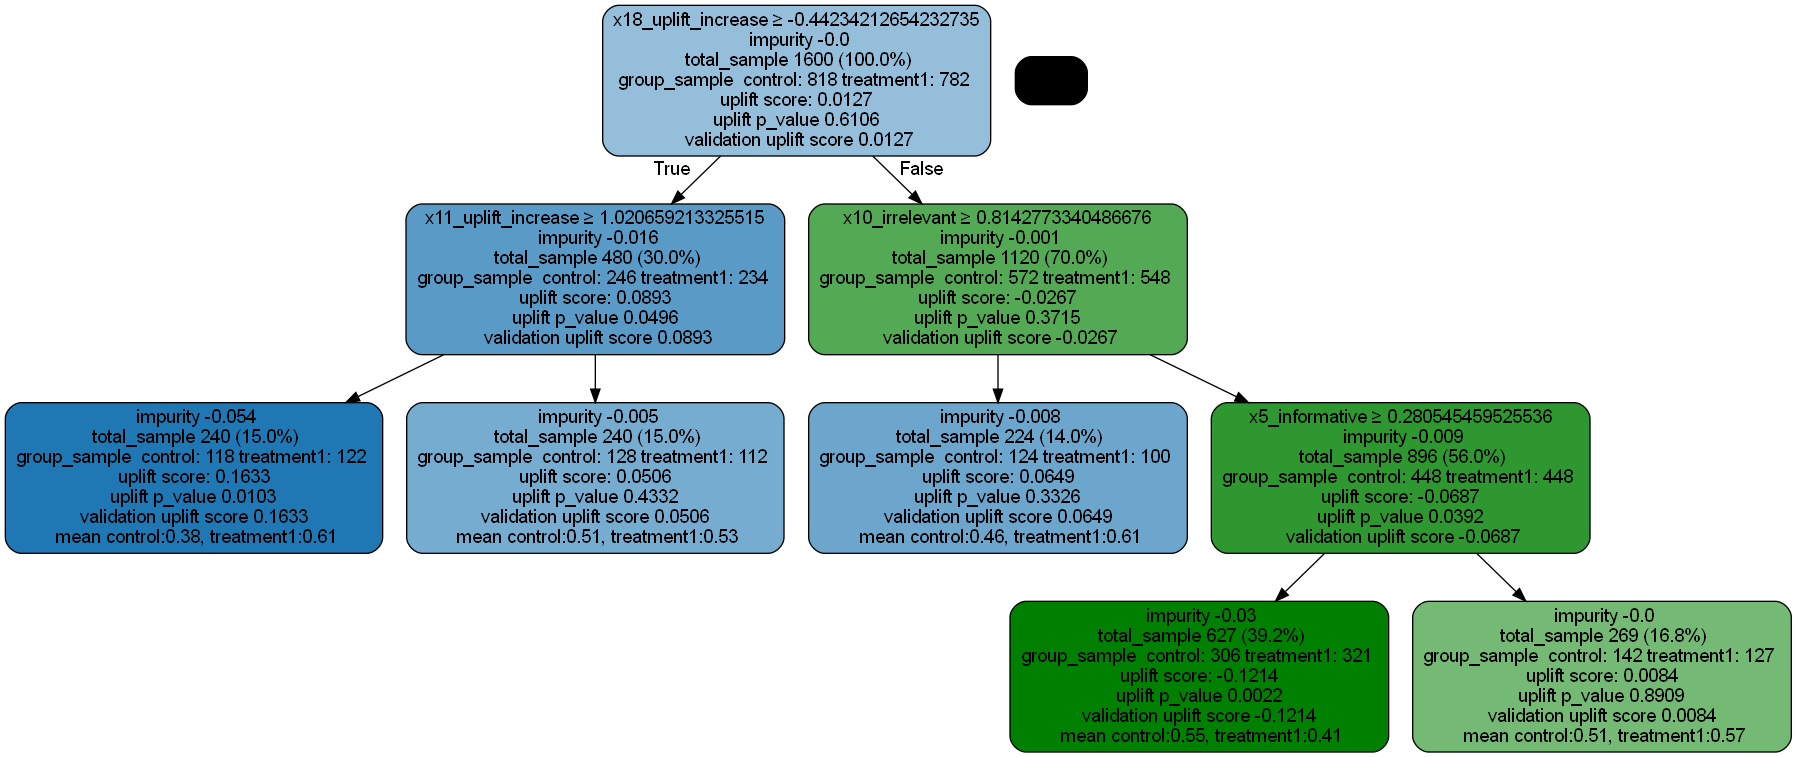

In [72]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

### Visualize Validation Tree: One Control + One Treatment for Uplift Classification Tree
Note the validation uplift score will update.

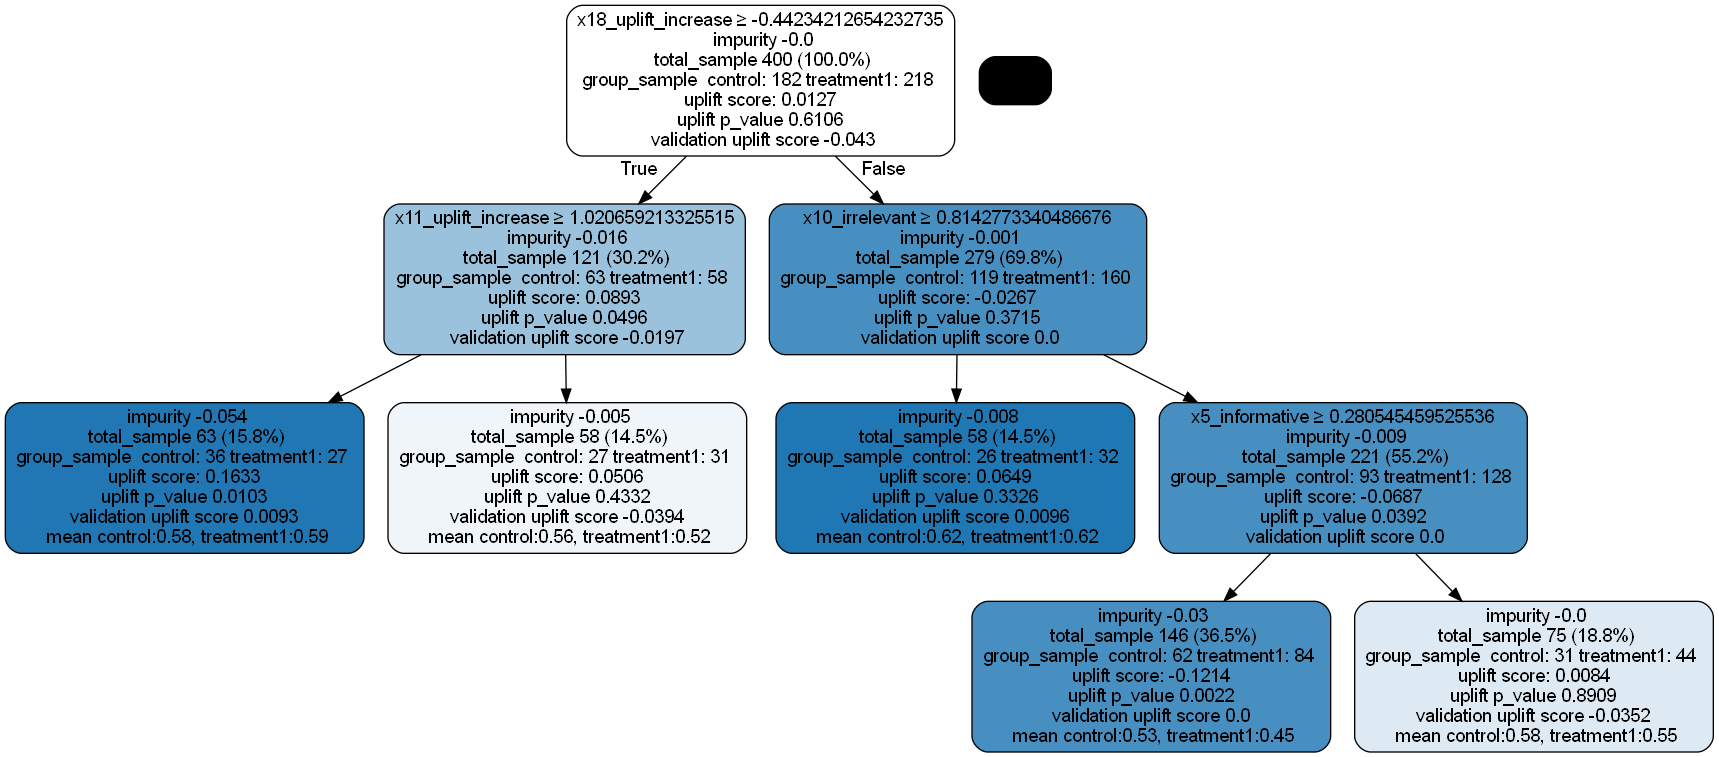

In [73]:
### Fill the trained tree with testing data set 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_model.fill(X=df_test[x_names].values, treatment=df_test['treatment_group_key'].values, y=df_test['conversion'].values)

# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

### Visualize a Tree in Random Forest

In [54]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftRandomForestClassifier(n_estimators=5, max_depth = 5, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [55]:
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model.uplift_forest[0]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names)

x10_irrelevant >= 0.8563694966652928?
yes -> x15_uplift_increase >= -0.5932741773938205?
		yes -> [0.3150684931506849, 0.7297297297297297, 0.63, 0.7027027027027027]
		no  -> [0.5529411764705883, 0.5753424657534246, 0.3902439024390244, 0.5316455696202531]
no  -> x18_uplift_increase >= -0.4313341857895426?
		yes -> x8_irrelevant >= -0.5552859944783076?
				yes -> x15_uplift_increase >= -0.9172565314735033?
						yes -> [0.44594594594594594, 0.49206349206349204, 0.7321428571428571, 0.7922077922077922]
						no  -> [0.463768115942029, 0.6271186440677966, 0.4473684210526316, 0.921875]
				no  -> [0.5405405405405406, 0.42592592592592593, 0.5686274509803921, 0.8235294117647058]
		no  -> x15_uplift_increase >= -1.9346970184433312?
				yes -> x7_irrelevant >= -0.061737934243997816?
						yes -> [0.4919786096256685, 0.37579617834394907, 0.625, 0.49238578680203043]
						no  -> [0.6610169491525424, 0.4117647058823529, 0.5333333333333333, 0.44]
				no  -> [0.48148148148148145, 0.494949494949495, 0

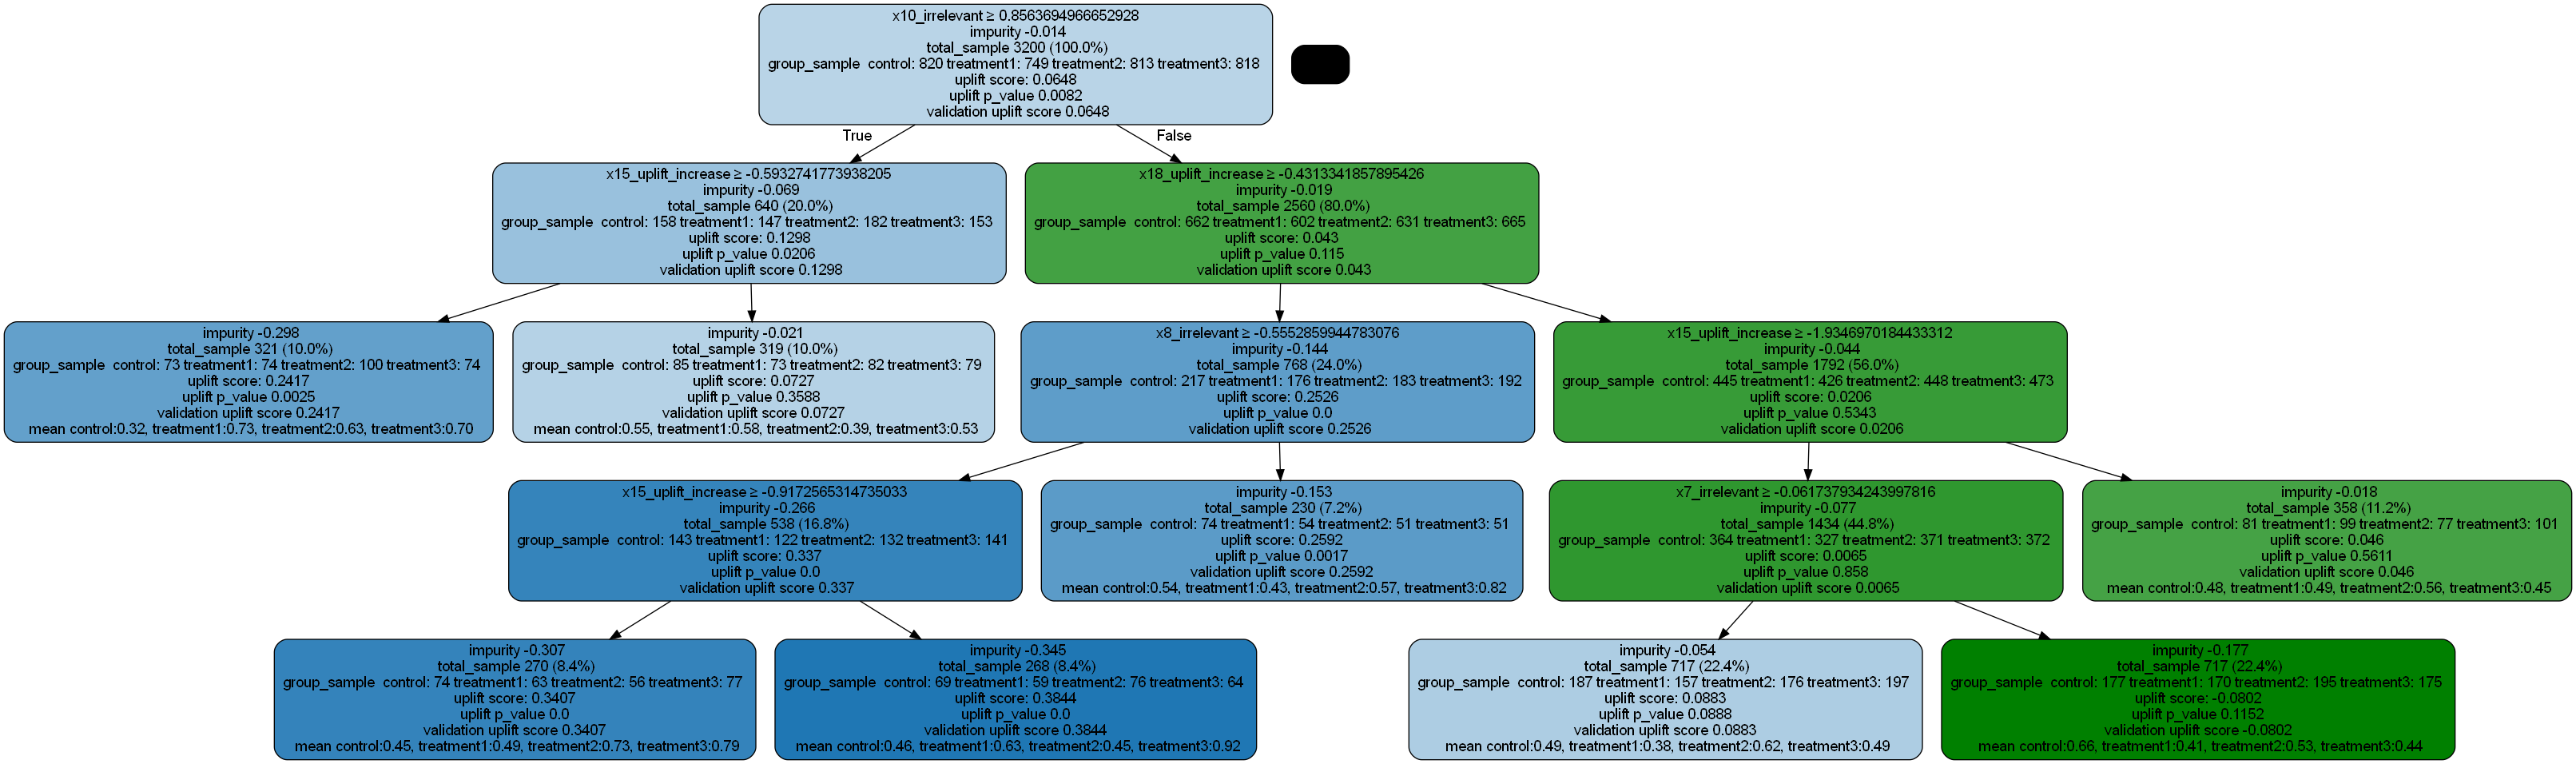

In [56]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

#### Fill the tree with validation data

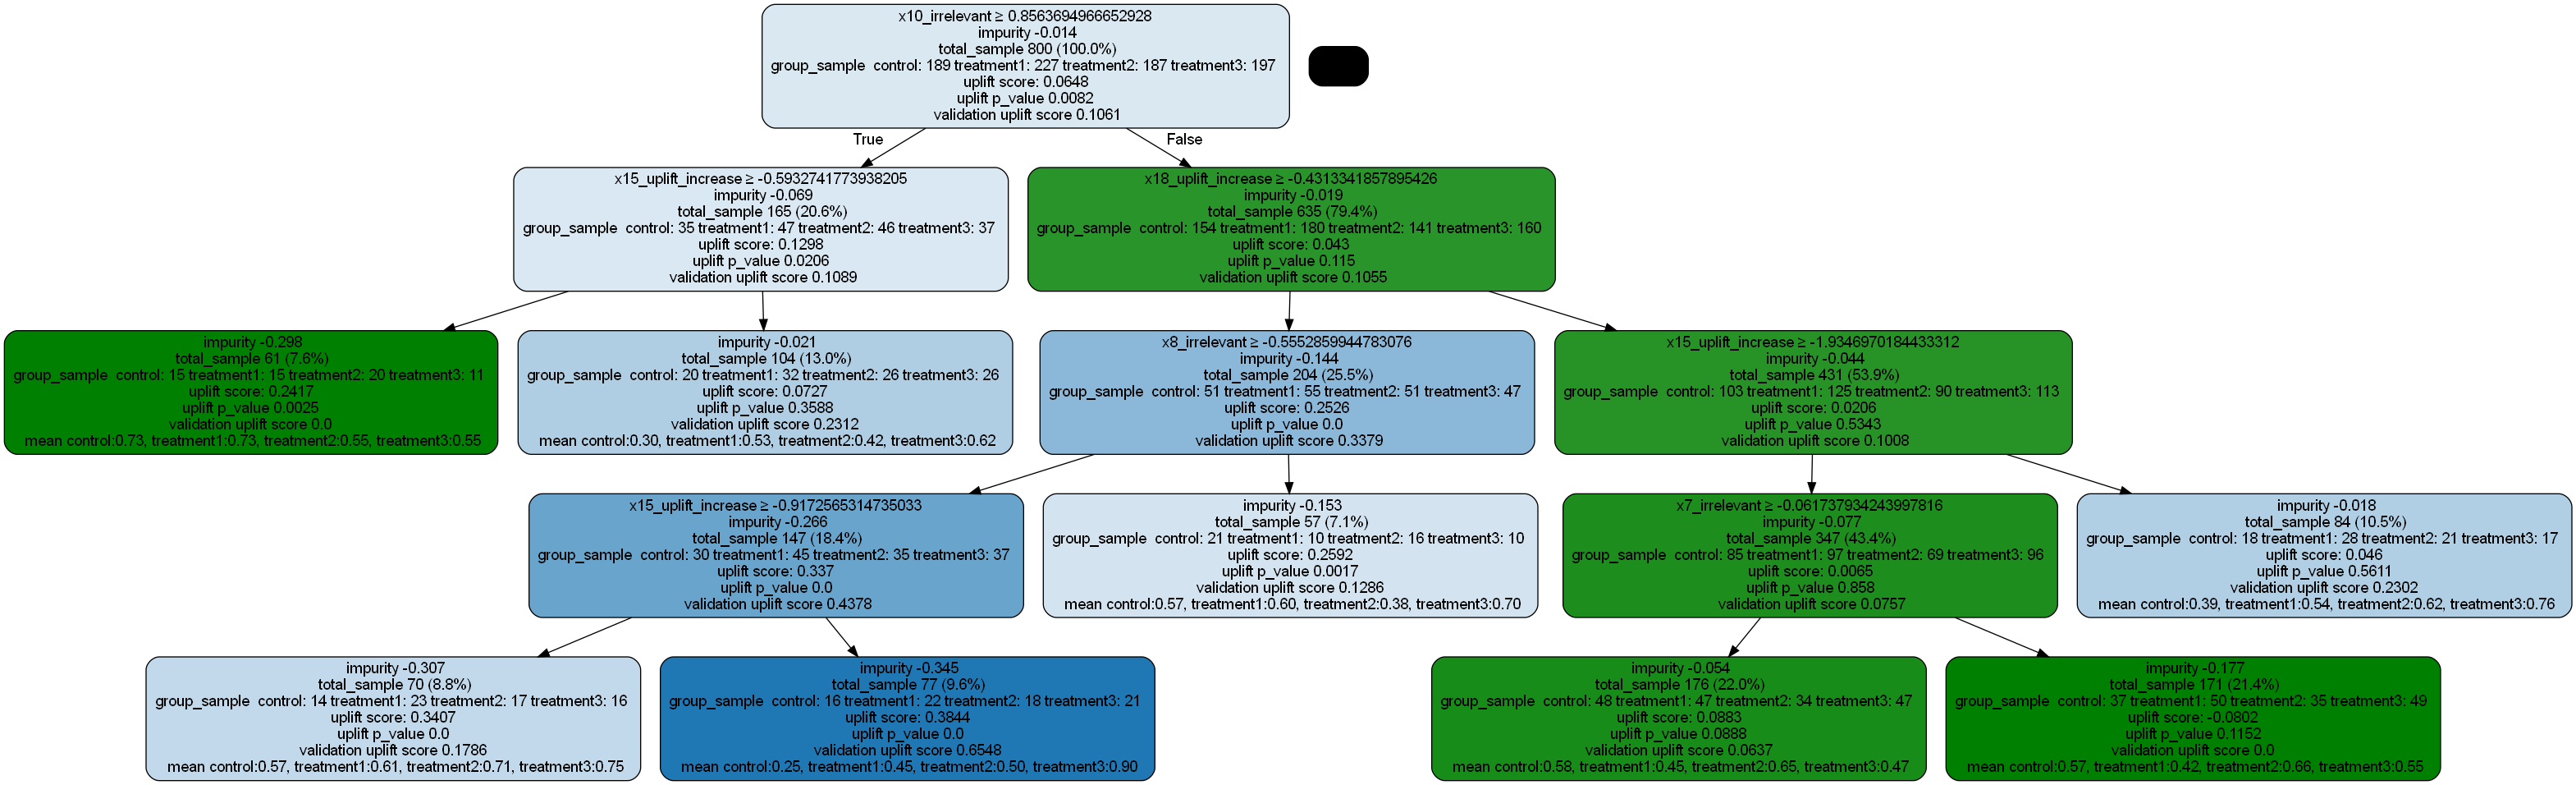

In [57]:
### Fill the trained tree with testing data set 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_tree.fill(X=df_test[x_names].values, treatment=df_test['treatment_group_key'].values, y=df_test['conversion'].values)

# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

## One Control + Multiple Treatments

In [58]:
# Data generation
df, x_names = make_uplift_classification()
# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


In [59]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 3, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

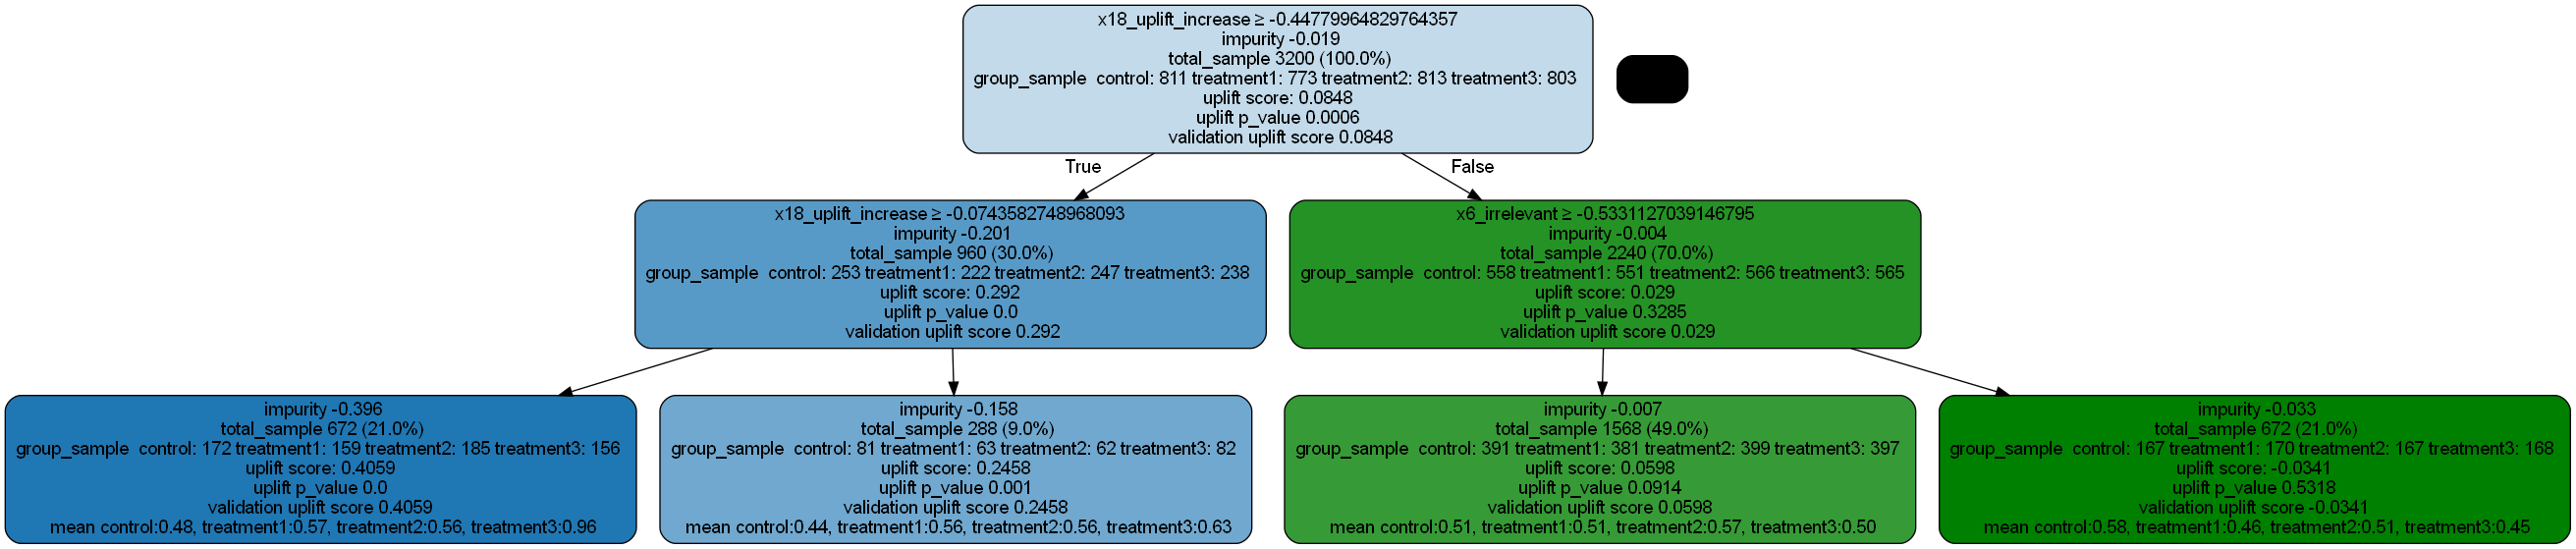

In [60]:
# Plot uplift tree
# The uplift score represents the best uplift score among all treatment effects
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

### Save the Plot

In [61]:
# Save the graph as pdf
graph.write_pdf("tbc.pdf")
# Save the graph as png
graph.write_png("tbc.png")

True